In [92]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00


In [93]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras_tuner as kt


column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)

In [94]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [95]:
data.shape

(506, 14)

In [96]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


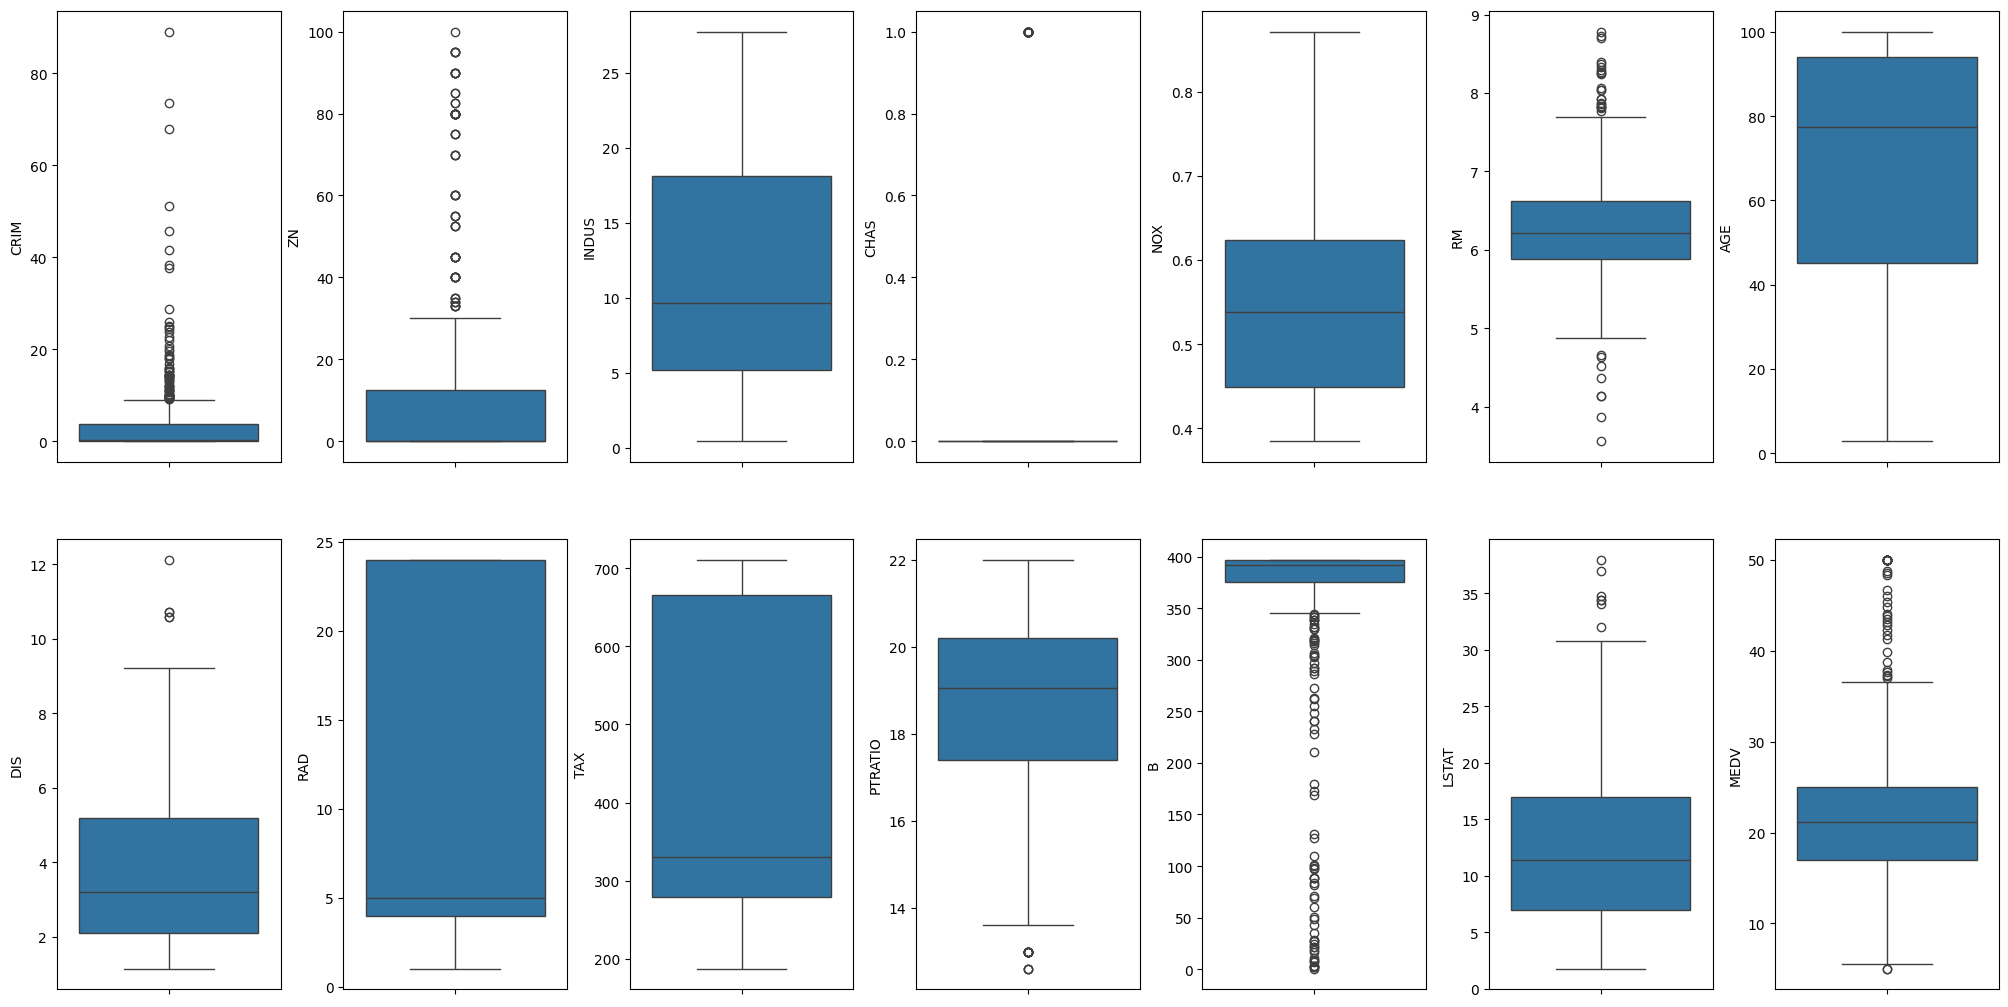

In [97]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

There is a lot of outliers. We should check the percentage of them

In [98]:
for k, v in data.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    outside = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = outside.shape[0] / data.shape[0] * 100.0
    print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


Removing MEDV outliers

In [99]:
data = data[~(data['MEDV'] >= 40.0)]

In [100]:
data.shape

(475, 14)

Visualizing features and target(MEDV) distribution

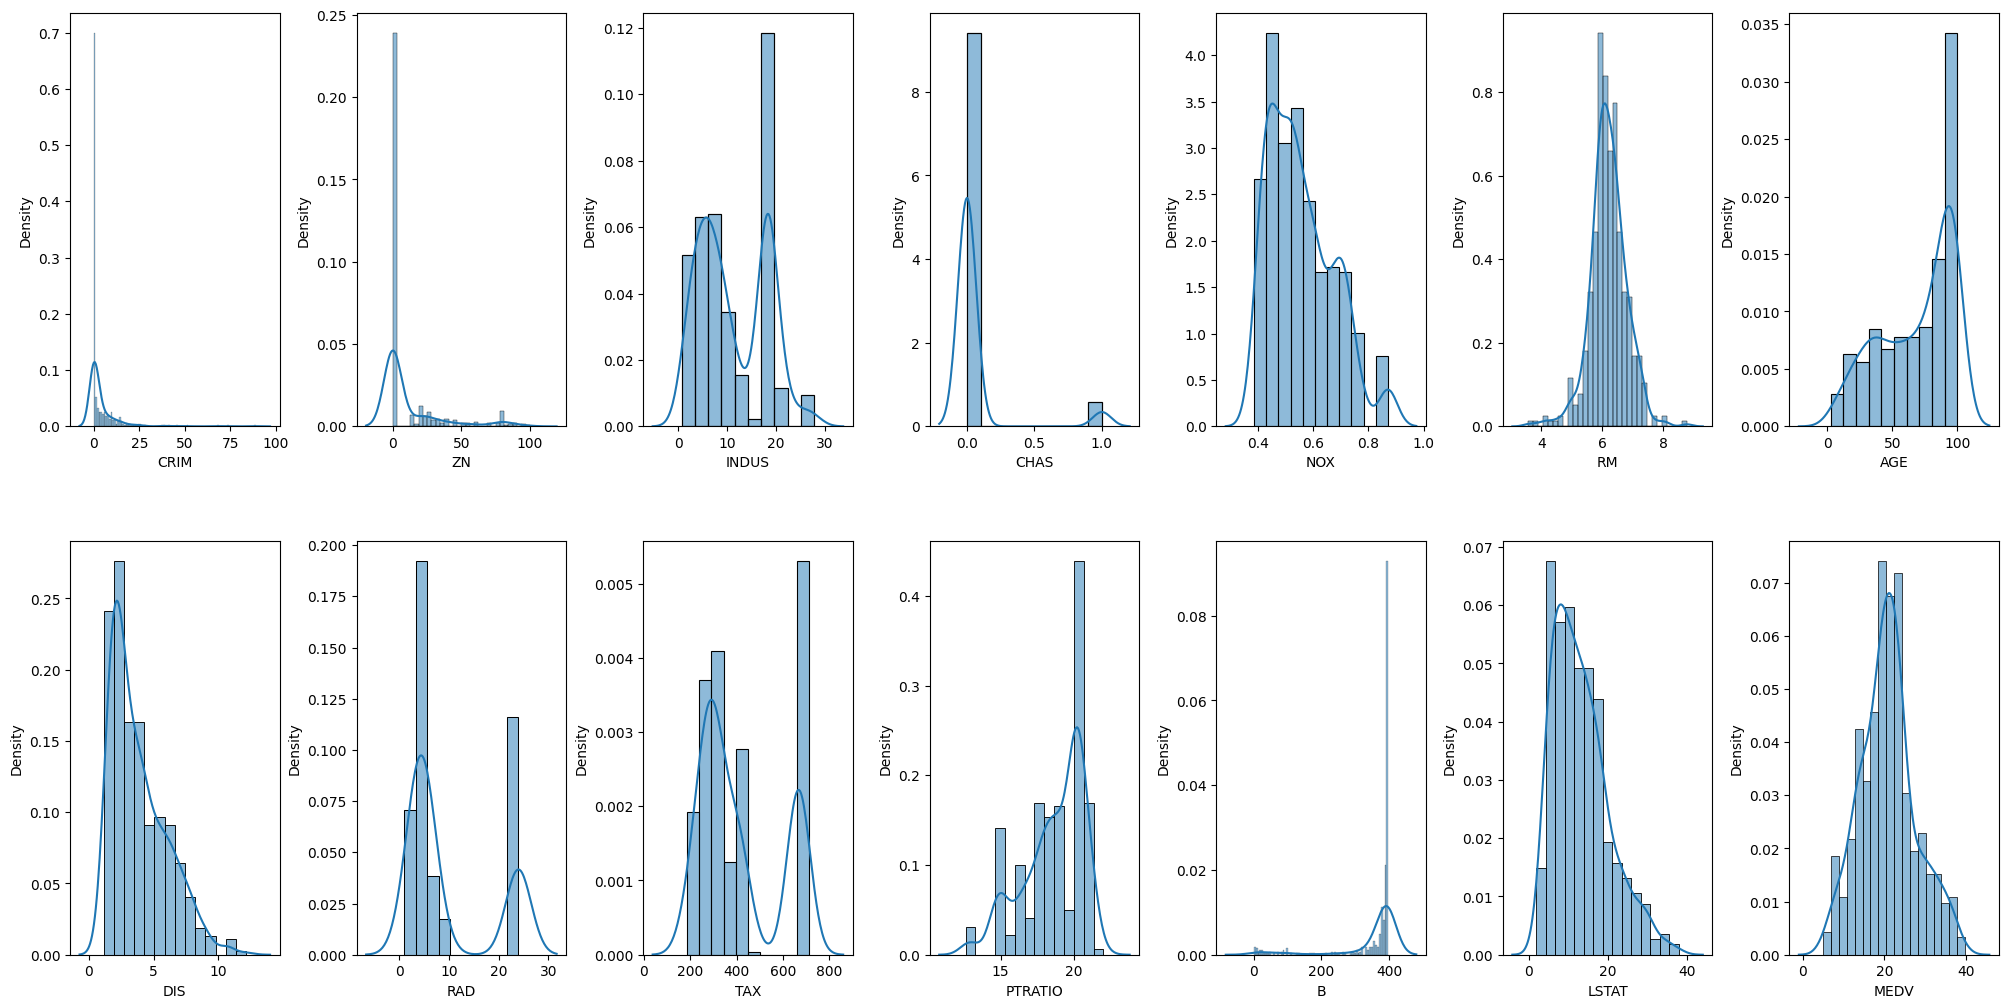

In [101]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.histplot(v, ax=axs[index],kde=True,stat="density", kde_kws=dict(cut=3))
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

A lot of features along with target have eather normal od bimodel distribution.
CRIM, ZN and B have highly skewed distributions.
CHAS is discrete.

Lets see their correlaton

<Axes: >

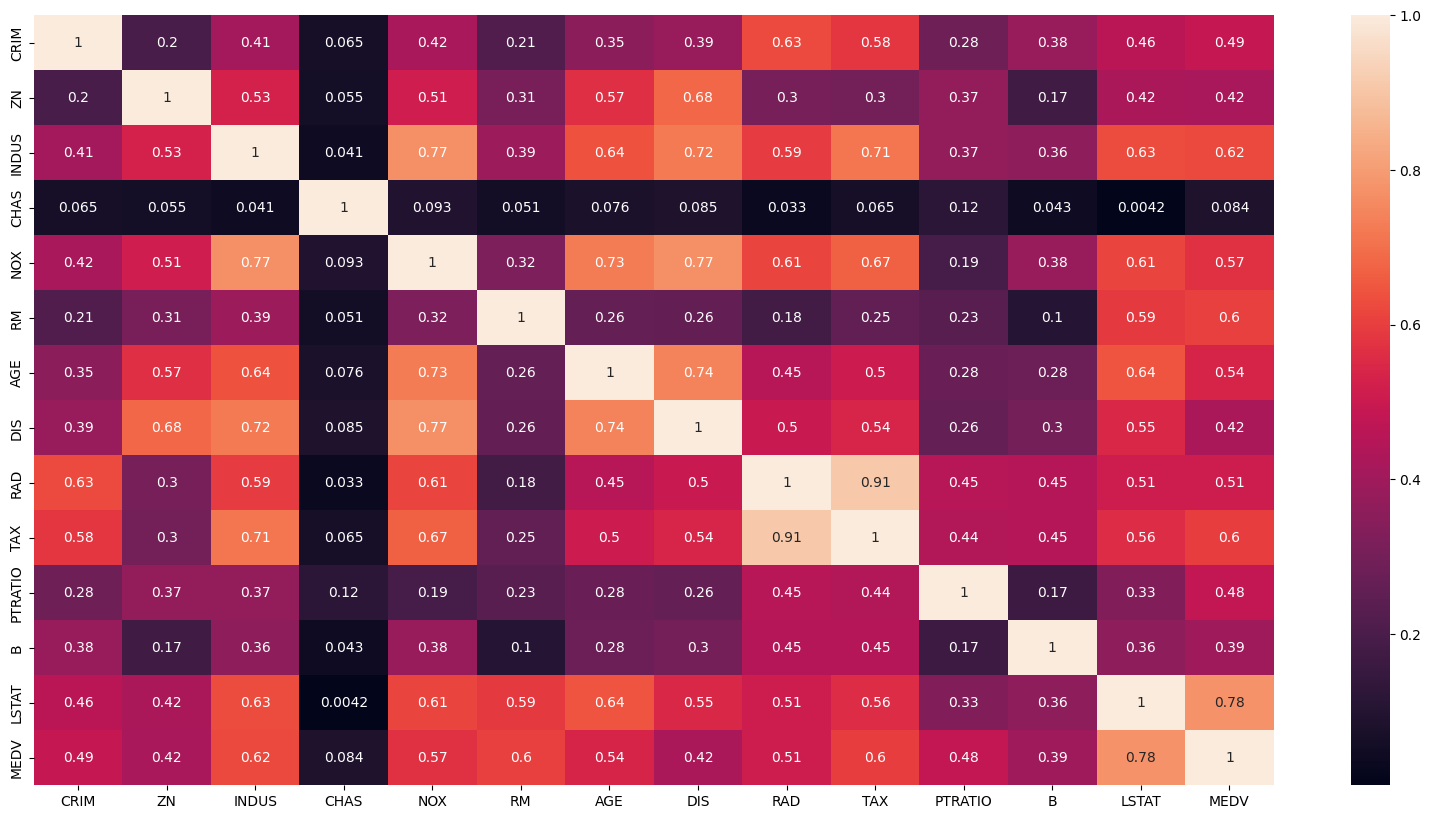

In [102]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV.

In [103]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
X = data.loc[:,column_sels]
y = data['MEDV']
X = pd.DataFrame(data=min_max_scaler.fit_transform(X), columns=column_sels)

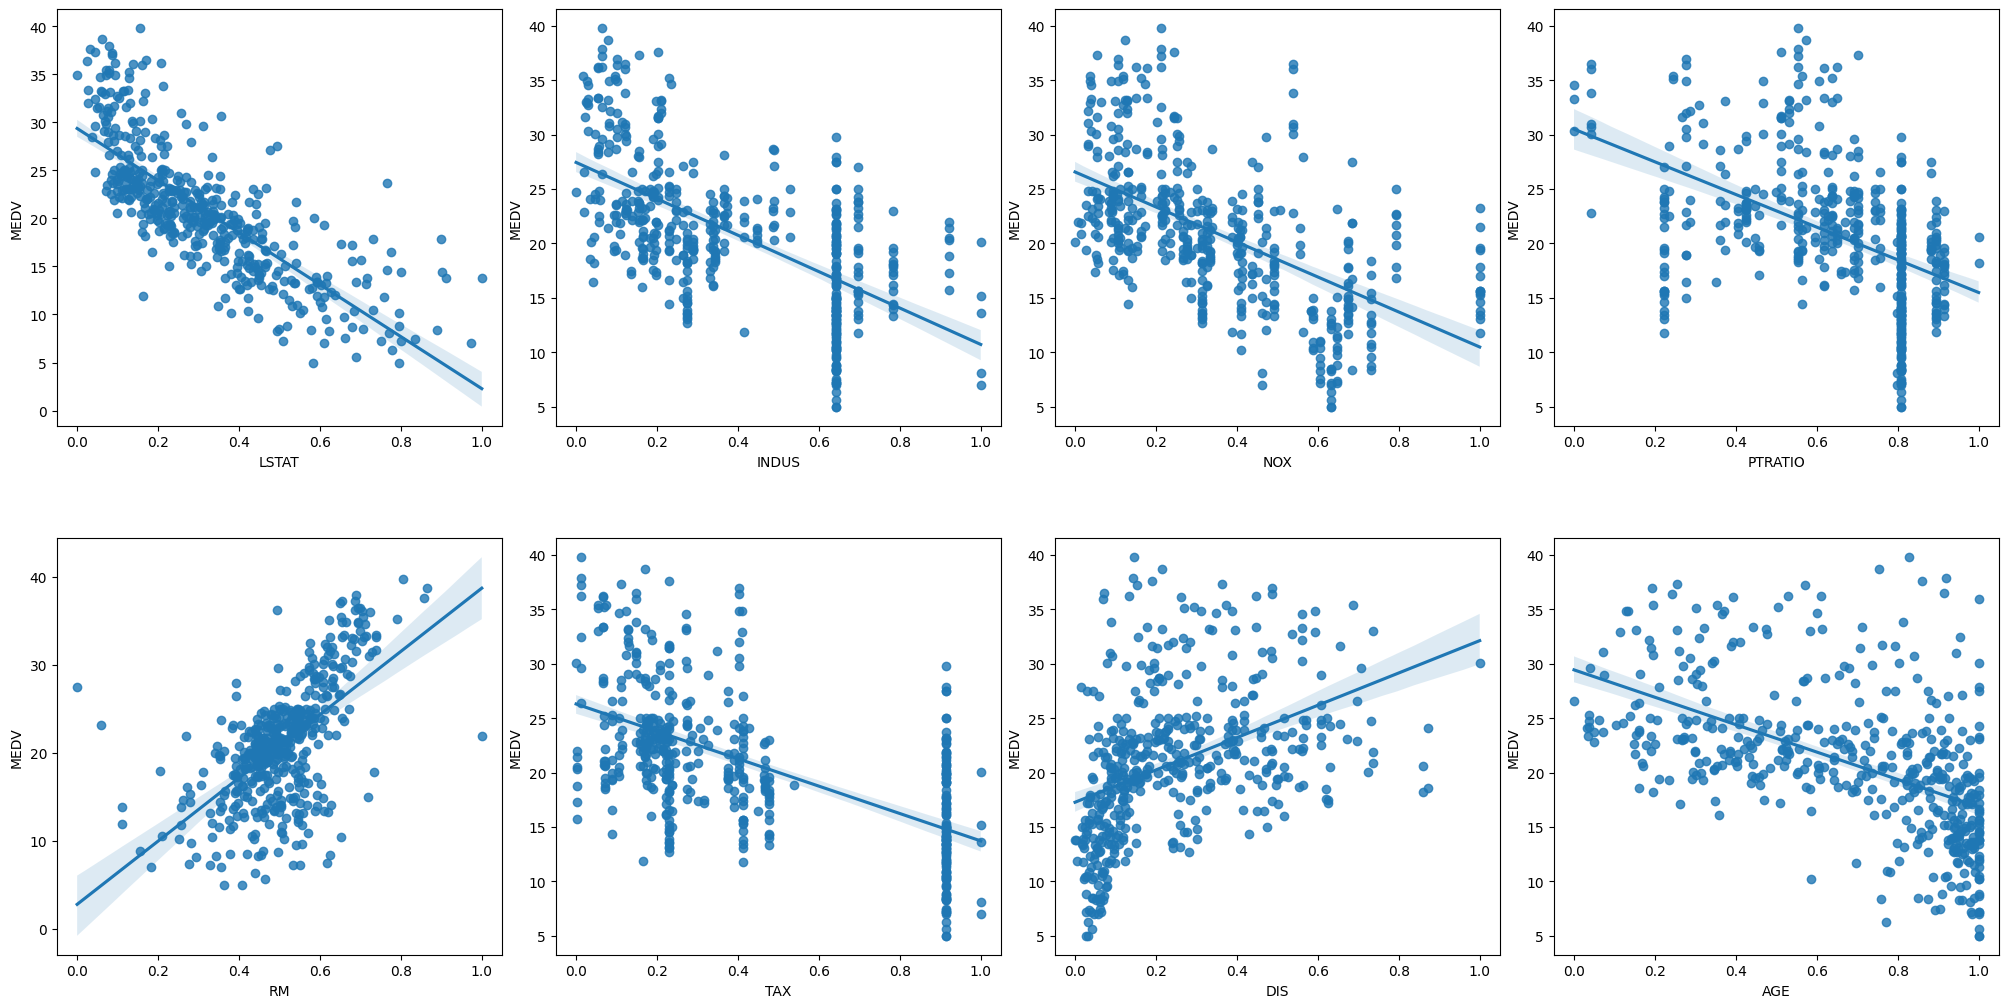

In [87]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=X[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [104]:
y =  np.log1p(y)
for col in X.columns:
    if np.abs(X[col].skew()) > 0.3:
        X[col] = np.log1p(X[col])

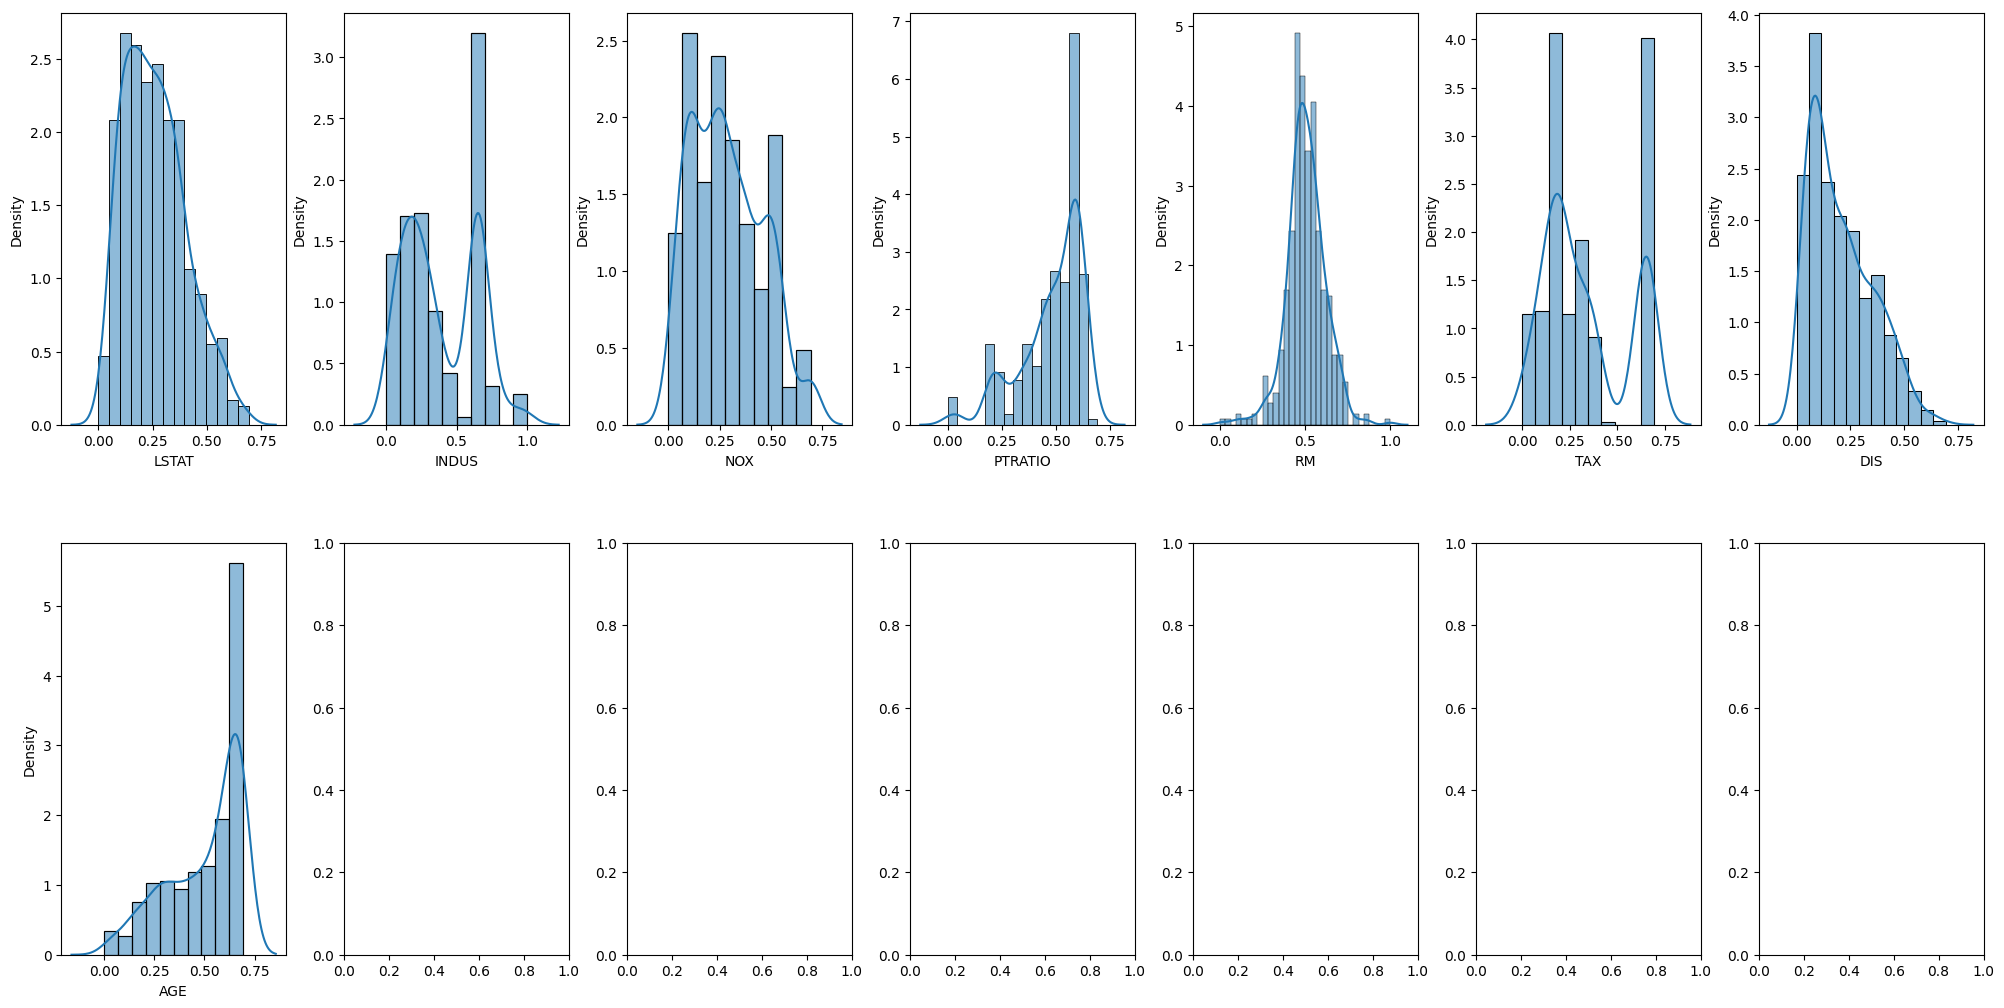

In [89]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in X.items():
    sns.histplot(v, ax=axs[index],kde=True,stat="density", kde_kws=dict(cut=3))
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [105]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.25,random_state = 42 , shuffle = False)

In [106]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(356, 8)
(119, 8)
(356,)
(119,)


In [167]:
def model_build(hp):
  model = tf.keras.Sequential()

  counter = 0
  for i in range(hp.Int("num_layers" , min_value=1 , max_value=4)):
    if counter == 0:
      model.add(tf.keras.layers.Dense(hp.Int("units" + str(i) , min_value = 8 , max_value = 128 , step = 8),
                                      activation = hp.Choice("activation" + str(i) ,values = ["relu","tanh","sigmoid"]),
                                      input_dim = 8))
    else:
      model.add(tf.keras.layers.Dense(hp.Int("units" + str(i) , min_value = 8 , max_value = 128 , step = 8),
                                      activation = hp.Choice("activation" + str(i) ,values = ["relu","tanh","sigmoid"]),
                                      input_dim = 8))
      if hp.Boolean("bool" + str(i)):
        model.add(tf.keras.layers.Dropout(hp.Choice("Dropout " + str(i) , values = [0.15,0.20,0.25,0.30])))

    counter += 1

  model.add(tf.keras.layers.Dense(1 , activation = None))

  model.compile(optimizer = hp.Choice("optimizer", values = ["adam","sgd","adagrad","rmsprop"]),
                  loss = "mae",
                  metrics = ["mae"])

  return model

In [168]:
tuner = kt.RandomSearch(model_build, objective = 'val_loss', max_trials = 15)

In [169]:
tuner.search(X_train ,y_train, epochs = 10, validation_data = (X_test , y_test))

Trial 15 Complete [00h 00m 03s]
val_loss: 1.8545931577682495

Best val_loss So Far: 0.2746294140815735
Total elapsed time: 00h 00m 46s


In [170]:
best_hp = tuner.get_best_hyperparameters()[0].values
best_hp

{'num_layers': 2,
 'units0': 96,
 'activation0': 'sigmoid',
 'optimizer': 'rmsprop',
 'units1': 40,
 'activation1': 'tanh',
 'bool1': False,
 'Dropout 1': 0.25}

In [ ]:
# model = tuner.get_best_models(num_models = 1)[0]
# early = tf.keras.callbacks.EarlyStopping(
#     monitor = "val_loss",
#     min_delta = 0.0001,
#     patience = 20,
#     verbose = True,
#     mode = "auto",
#     baseline = None,
#     restore_best_weights = True)
# Model = model.fit(X_train,y_train , epochs = 200, initial_epoch = 40 , validation_split = 0.25 , callbacks = early)

In [171]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(96, activation = "sigmoid", input_dim = 8))
model.add(tf.keras.layers.Dense(40, activation = "tanh"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1 , activation = None))

model.compile(optimizer = "rmsprop", loss = "mae", metrics = ["mae"])

history = model.fit(X_train,y_train , epochs = 200)

Epoch 1/200
12/12 [==============================] - 1s 3ms/step - loss: 1.0929 - mae: 1.0929
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3796 - mae: 0.3796
Epoch 3/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4203 - mae: 0.4203
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4242 - mae: 0.4242
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3867 - mae: 0.3867
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 0.3677 - mae: 0.3677
Epoch 7/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3545 - mae: 0.3545
Epoch 8/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3670 - mae: 0.3670
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 0.3371 - mae: 0.3371
Epoch 10/200
12/12 [==============================] - 0s 2ms/step - loss: 0.3377 - mae: 0.3377
Epoch 11/200
12/12 [==============================] - 0s 3m

In [172]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 96)                864       
                                                                 
 dense_4 (Dense)             (None, 40)                3880      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                                 
Total params: 4785 (18.69 KB)
Trainable params: 4785 (18.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [173]:
history.history.keys()

dict_keys(['loss', 'mae'])

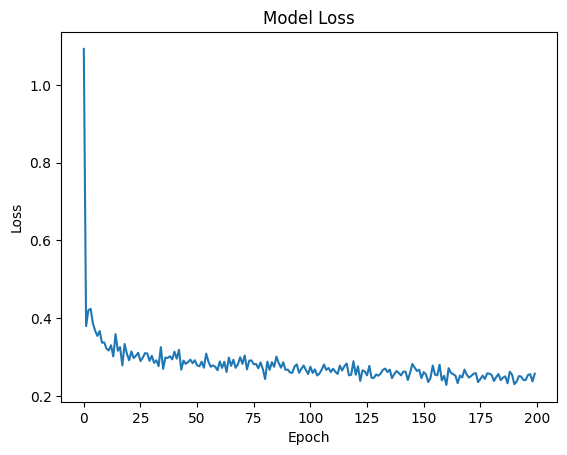

In [175]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.show()

In [176]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [183]:
tf.squeeze(y_pred) - y_test

<tf.Tensor: shape=(119,), dtype=float32, numpy=
array([-0.03981614, -0.32926798, -0.24195194, -0.40335655, -0.8037338 ,
       -0.19842482, -0.22991896, -0.20495129, -0.19241524, -0.19123554,
        0.08639407,  0.35491943,  0.2221781 ,  0.36478376,  0.2854991 ,
       -0.1787889 ,  0.07155919, -0.04335451,  0.4944377 , -0.415591  ,
       -0.8835707 , -0.66236544, -0.8866861 , -0.23318458, -0.48285294,
       -0.91481876, -0.56040144, -0.1152873 ,  0.15203094,  0.2053361 ,
       -0.23879457,  0.05994582,  0.16314864, -0.39495683, -0.29148006,
       -0.640754  , -0.3420155 , -0.15113306,  0.04526234,  0.03807187,
        0.01071262, -0.12288642, -0.02596855, -0.29458904, -0.26384878,
       -0.27703524, -0.27256393, -0.09142375, -0.31560946,  0.06603384,
       -0.01414824, -0.10115933, -0.35496736, -0.14192581, -0.5041311 ,
       -0.54039884, -0.3858385 , -0.19497919, -0.22191596, -0.35049272,
       -0.18246388, -0.3235953 , -0.24359798, -0.20713139, -0.34373617,
       -0.420173

In [185]:
np.mean(y_test), np.median(y_test)

(2.729007575619203, 2.766319109226186)